In [2]:
from stable_baselines3 import DDPG
import gym
from gym import spaces
import pandas as pd
import numpy as np
import torch

In [464]:
# Starting to look good!

# Custom environment
class PortfolioChoice(gym.Env):

  def __init__(self, T):
    super(PortfolioChoice, self).__init__()
    # Actions are (risk_alloc, consumption)
    self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), high=np.array([1.0, 1.0]), dtype=np.float32)
    # Observations are (wealth, time)
    self.observation_space = spaces.Box(low=np.array([0.0, 0.0]), high=np.array([np.inf, 1.0]), dtype=np.float64)

    self.initial_action = None
    self.curr_wealth = 1.0
    self.curr_time = 0
    self.horizon = 10
    self.bequest = 0.1
    self.risk_aversion = 1 # log utility
    self.rho = 0.05

  # action space is [-1, 1]
  def rescale_riskalloc(self, risk_alloc):
    return (risk_alloc)*2+1
  def rescale_consumption(self, consumption):
    return (consumption+1)/2

  def update_wealth(self, action, time_step):
    time_scale = time_step*self.horizon # scaling returns based on time
    exp_return = 0.08
    rf_rate = 0.05
    sd_return = 0.15
    curr_wealth = self.curr_wealth
    risk_alloc = self.rescale_riskalloc(action[0])
    consumption = self.rescale_consumption(action[1])
    returns = np.max((rf_rate + risk_alloc*(exp_return - rf_rate) - consumption - sd_return**2/2)*time_scale + risk_alloc*sd_return*np.random.normal(loc=0, scale=time_scale),-1)
    self.curr_wealth = curr_wealth*(1+returns)
  
  # consumption policy means fraction of current wealth consumed on an annualized basis 
  def calculate_utility(self, consumption):
    period = self.curr_time*self.horizon
    utility = np.log(1+consumption*1e6)*np.exp(-self.rho*period)
    return utility

  def step(self, action, time_step=0):
    # bit of a hack here so I can manually input timesteps
    if time_step==0:
      time_step = 1/np.random.random()*1/self.horizon
    curr_time = self.curr_time
    
    # only choose the action once
    if curr_time==0:
      self.initial_action = action[0]
    else:
      action[0] = self.initial_action

    # check if end of simulation has been reached
    if curr_time + time_step>=1:
      time_step = 1 - curr_time
      done = True
    else:
      done = False

    # calculate reward
    consumption = self.rescale_consumption(action[1])*self.curr_wealth
    reward = self.calculate_utility(consumption)

    self.curr_time += time_step
    self.update_wealth(action, time_step)

    if done==True and self.curr_wealth > 0:
      reward += self.bequest*self.calculate_utility(self.curr_wealth)

    # floor wealth at 0, trigger an exit
    if self.curr_wealth <= 0:
      self.curr_wealth = 0
      done = True

    obs = np.array([self.curr_wealth, self.curr_time])
    info = {}

    return obs, reward, done, info

  def reset(self):
    self.curr_wealth = 1.0
    self.curr_time = 0
    return np.array([1.0, 0.0])


In [465]:
from stable_baselines3.common.env_checker import check_env
env = PortfolioChoice(10)
check_env(env)

c:\Users\paulw\Anaconda3\envs\openai\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [466]:

from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG, TD3
import torch as th

env = PortfolioChoice(10)

n_actions = env.action_space.shape[-1]
param_noise = None
# slow the learning rate? make the network bigger? higher sigma here?
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5)*np.ones(n_actions))
# policy_kwargs = dict(net_arch=dict(pi=[64, 32], qf=[256, 128]))
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[256, 128, 64]))

td3_model = TD3(MlpPolicy, env, verbose=1, action_noise=action_noise, policy_kwargs=policy_kwargs) # , learning_starts=512, batch_size=512
td3_model.learn(total_timesteps=30000)
#td3_model.save("td3_estimates")

# my future utility is already discounted, should I use gamma? bigger batches?
# model = DDPG(MlpPolicy, env, verbose=1, action_noise=action_noise, policy_kwargs=policy_kwargs, gamma=1.0) # , learning_starts=512, batch_size=512
# model.learn(total_timesteps=20000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5      |
|    ep_rew_mean     | 27.7     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2505     |
|    time_elapsed    | 0        |
|    total_timesteps | 10       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.62     |
|    ep_rew_mean     | 28.3     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2631     |
|    time_elapsed    | 0        |
|    total_timesteps | 21       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.33     |
|    ep_rew_mean     | 25.8     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

<AxesSubplot:>

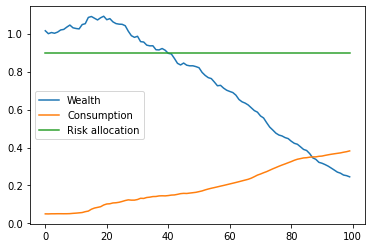

In [488]:
obs = env.reset()
results = []
for n in range(100):
    action, _states = td3_model.predict(obs)
    obs, rewards, dones, info = env.step(action,0.01)
    risk_alloc = (action[0])*2+1
    consumption = (action[1]+1)/2
    wealth = obs[0]
    time = obs[1]*10
    results.append([wealth, consumption, risk_alloc])

results = pd.DataFrame(results)
results.columns = ['Wealth', 'Consumption', 'Risk allocation']

pd.DataFrame(results).plot()
